### GWR 和 MGWR 示例
***
这是一个基本示例笔记本，演示了如何校准 GWR 或 MGWR 模型。

#### 安装
`pip install mgwr`

In [1]:
#pip install mgwr

Load packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

Load voting dataset

In [8]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020.csv')

voting[['median_income']] = voting[['median_income']]/10000

In [9]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [10]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP').geometry.boundary

In [11]:
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']


y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

在 GWR 或 MGWR 中，我们经常建议对独立变量和因变量进行标准化。这里的标准化意味着我们减去平均值并除以标准化值。

这种方法的好处是，获得的系数变得“无单位”，允许跨变量和位置比较变量重要性。

In [12]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

我们需要将坐标输入到 GWR。

In [13]:
coords = shp_voting[['proj_X', 'proj_Y']].values

#### 两步拟合 GWR 模型
- 选择最佳带宽
- 使用最佳带宽拟合 GWR 模型
***
默认内核是自适应（最近邻居数）双平方。

In [18]:
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1219.0 , score:  4058.94
Bandwidth:  1938.0 , score:  4614.76
Bandwidth:  774.0 , score:  3557.79
Bandwidth:  499.0 , score:  3140.51
Bandwidth:  329.0 , score:  2802.09
Bandwidth:  224.0 , score:  2530.12
Bandwidth:  159.0 , score:  2375.52
Bandwidth:  119.0 , score:  2310.56
Bandwidth:  94.0 , score:  2291.48
Bandwidth:  79.0 , score:  2297.64
Bandwidth:  104.0 , score:  2296.46
Bandwidth:  89.0 , score:  2289.15
Bandwidth:  85.0 , score:  2289.31
Bandwidth:  91.0 , score:  2289.59
Bandwidth:  87.0 , score:  2291.76
Selected optimal bandwidth is: 89.0


使用最佳 bw 拟合模型

In [19]:
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

GWR 输出摘要

In [20]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1213.006
Log-likelihood:                                                   -2945.693
AIC:                                                               5905.385
AICc:                                                              5907.432
BIC:                                                             -23679.220
R2:                                                                   0.609
Adj. R2:                                                              0.608

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

局部估计值可以从`gwr_results.params`中获得，它返回一个 n x p 数组，其中 p 是模型中的预测变量的数量（包括截距）。

In [23]:
variable_names

['sex_ratio',
 'pct_black',
 'pct_hisp',
 'pct_bach',
 'median_income',
 'ln_pop_den']

In [24]:
gwr_results.params[:,4]

array([ 0.56501565,  0.61552673,  0.42141522, ..., -0.09090834,
        0.75477483,  0.39401467])

Text(0.5, 1.0, 'Coefficients of ln_pop_den')

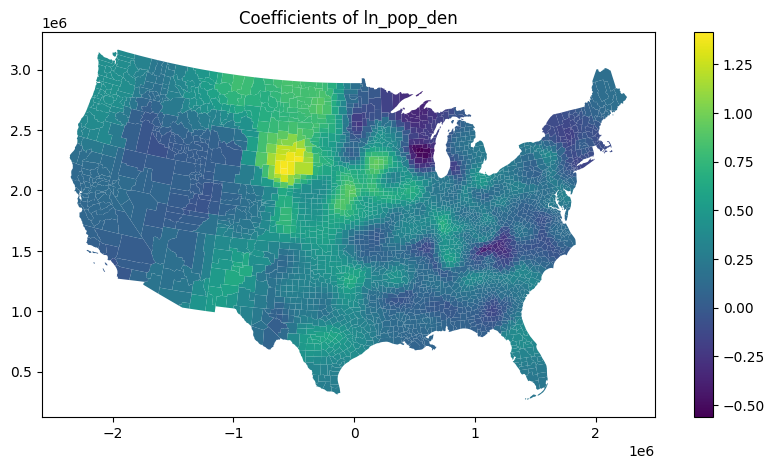

In [27]:
from matplotlib import colors

ax = shp_voting.plot(column=gwr_results.params[:,6],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of ln_pop_den",fontsize=12)

编写一些绘图代码，将参数估计表面全部可视化。我们需要将 GWR 结果与县 GeoDataFrame 连接起来。

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False,figsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### 以下是从 GWR 获得的参数估计图。每个图代表每个预测因子与 PctBach 之间的空间关系。

- 正（负）关系以红色（蓝色）显示。
- 较强（较弱）的关系颜色较深（较浅）。

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_19922/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


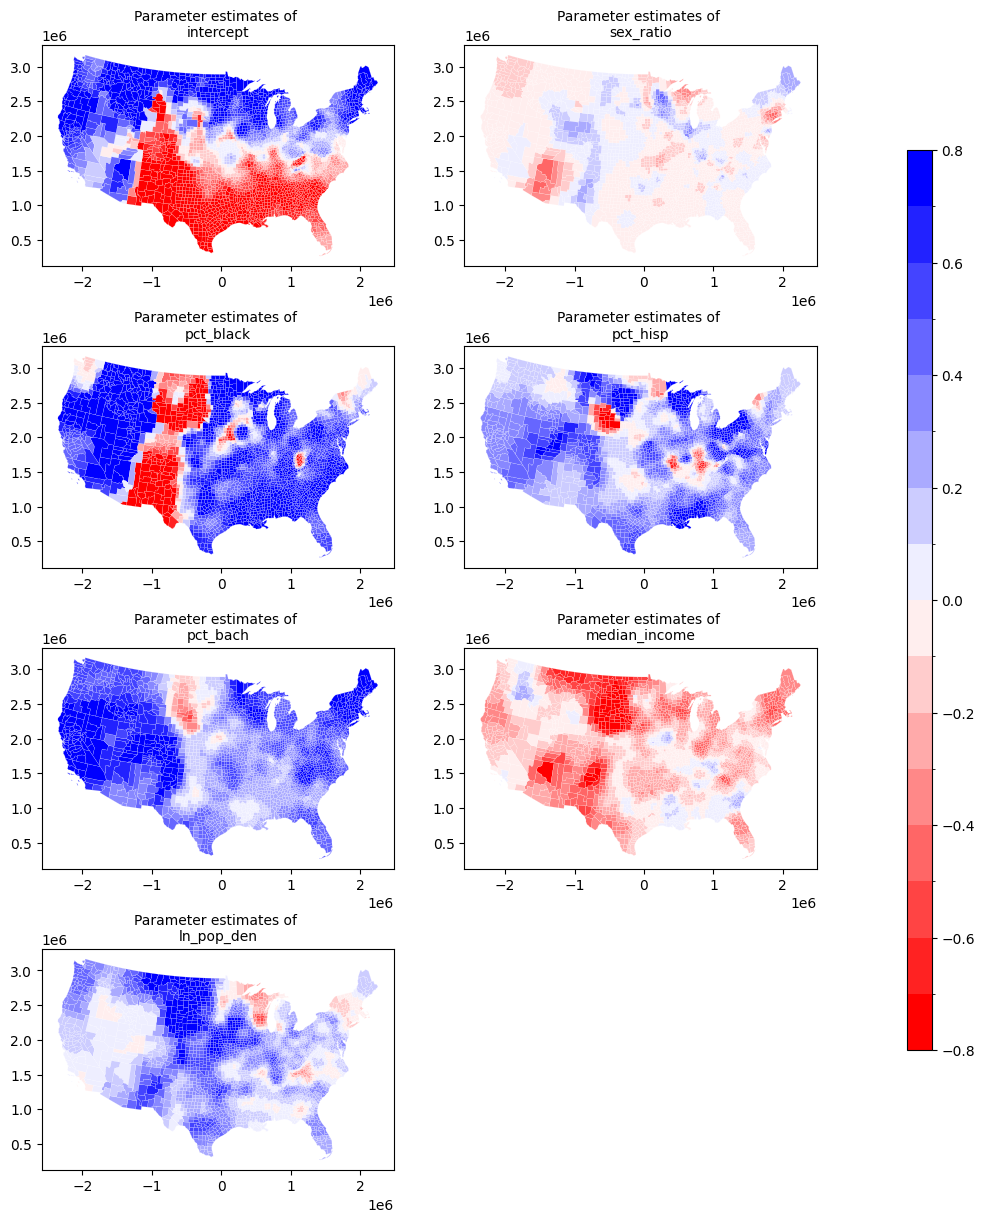

In [29]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15))

现在让我们检查一下 GWR 模型的残差。

In [15]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/2963299590.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


0.1142496644549166

我们经常会观察到 GWR 模型的残差具有较低的 Moran's I 值，这表明已考虑了空间结构。局部截距是一种内在背景效应，例如，表明有多少影响可以归因于“位置”。



### GWR 推断

局部系数显著性

#### 以下是**显著性（p<0.05）**参数估计值的图。显著性检验已调整以解决多重检验问题（Bonferroni）。

不显著的参数用灰色遮盖。

这是通过 `param_plots()` 函数中的 `result.filter_tvals()` 完成的。


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3391375418.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


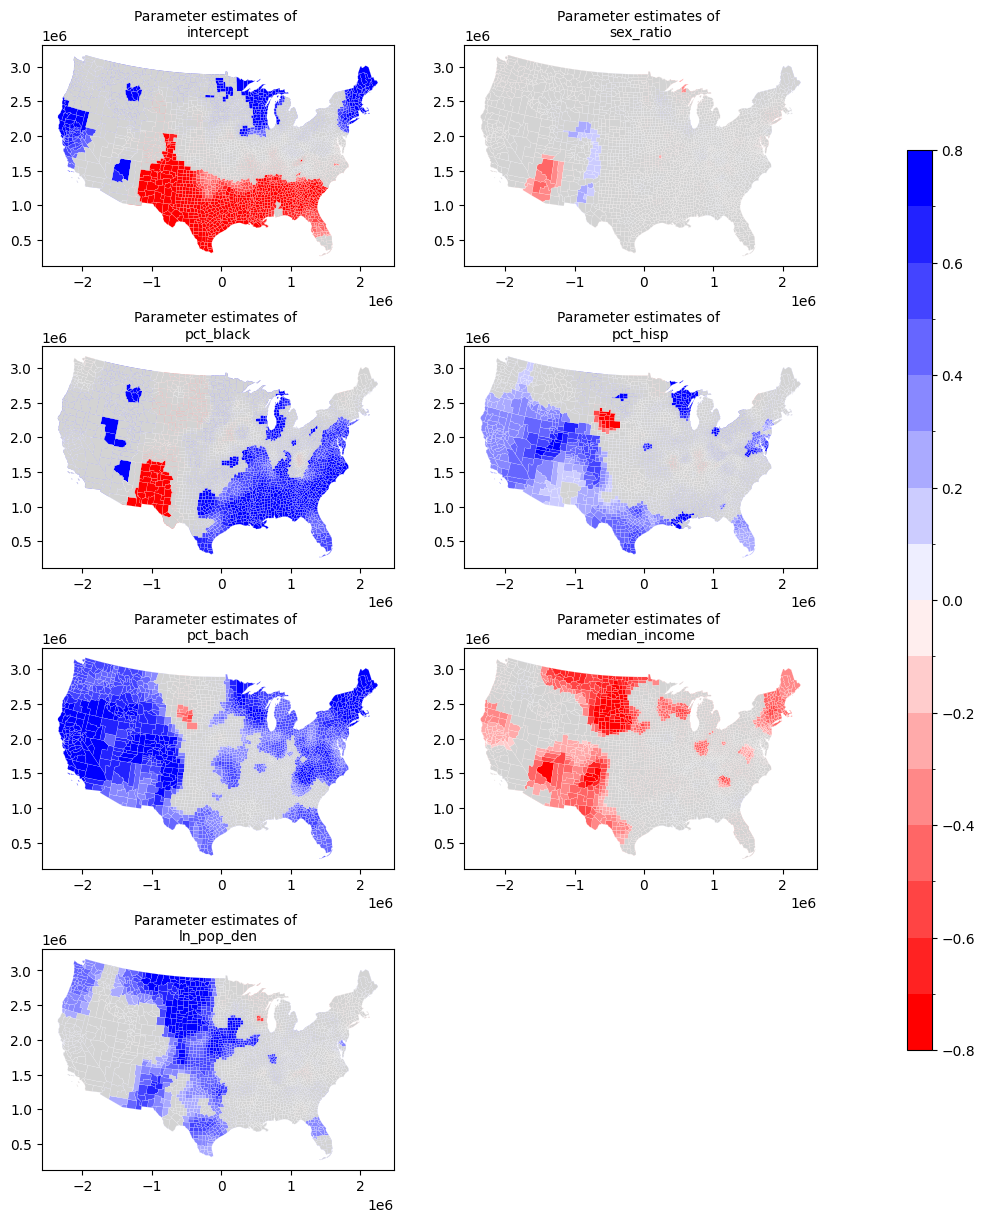

In [16]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

#### 两步拟合 MGWR 模型
- 寻找最佳带宽
- 使用最佳带宽拟合 MGWR 模型
***

**注意**：当数据超过 5,000 条记录时，MGWR 会变慢。

In [ ]:
%%time
mgwr_selector = Sel_BW(coords, y, X,multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

In [ ]:
mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

In [19]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1213.006
Log-likelihood:                                                   -2945.693
AIC:                                                               5905.385
AICc:                                                              5907.432
BIC:                                                             -23679.220
R2:                                                                   0.609
Adj. R2:                                                              0.608

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [20]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3541487640.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


0.01835193713566798

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_14666/3391375418.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


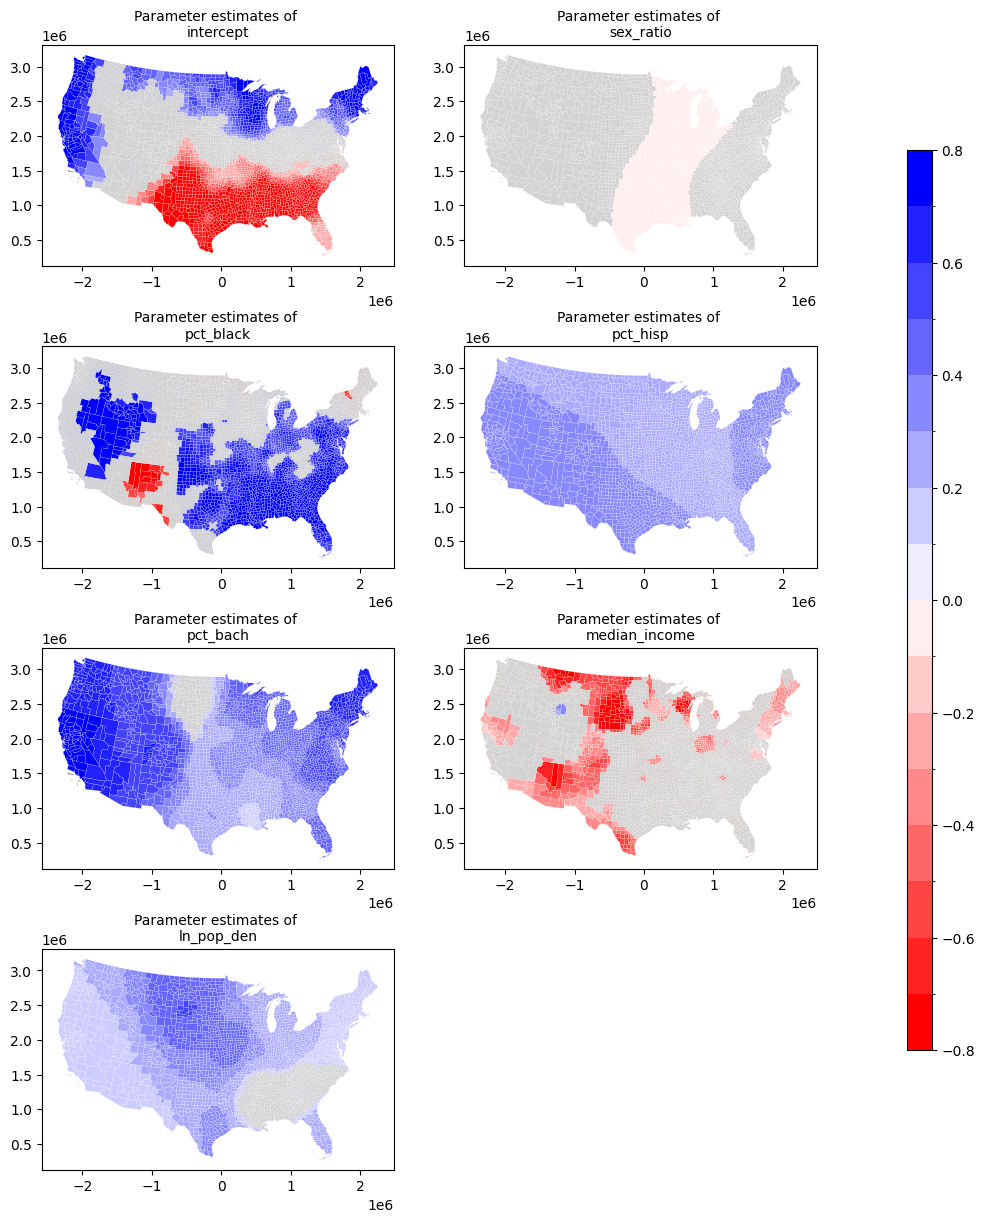

In [21]:
param_plots(mgwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

We can see that the relationships will vary at different spatial scales.

### OLS vs. GWR vs. MGWR

From the comparison, we can clearly see an advantage of MGWR over GWR by allowing the bandwidth to vary across covariates.

| Metric    | OLS    | GWR   | MGWR   |
| -----------  | ----------- | ----------- | ----------- |
| R2     | 0.609       | 0.920        | 0.928      |
| AICc    | 5907.4        | 2289.1        | 1802.7      |
| Moran's I of residuals    | 0.60      | 0.11       | 0.018       |
